In [150]:
import pandas as pd
import nltk
import re
import pymorphy2
from wordcloud import WordCloud

Загружаем данные (выбрал основной текст поста (body); можно было бы загружать комментарии или ответы, но решил остановиться сначала на основном тексте):

In [151]:
def load_data(data_path="./data/QueryResults.csv"):
    return pd.read_csv(data_path)

In [152]:
data = load_data()
data.head()

,Body
0,<p>I found a way that seems to at least load t...
1,<pre><code>mysql&gt; explain SELECT col3 FROM ...
2,"<p>After a lot of searching around, I found th..."
3,<p>I want remove special character from <code>...
4,<p>You can't use minus sign in object name dep...


Загружаем стоп-слова:

In [153]:
stopwords = nltk.corpus.stopwords.words('english')

Обработка текста: сначала выкидываем код, ссылки, синтаксис html; затем делим на токены, проверяем что является словом и что не является стоп-словом.

In [154]:
def process_text(text):
    # В данных есть nan
    if isinstance(text, str):
        # Не использую Beautiful Soup, т.к. он удаляет теги, но оставляет текст. Нам же нужно убрать целиком блоки, потому что кажется,
        # что в них ничего интересного не будет
        cleaned_text = re.sub("<pre><code>.*?</code></pre>|<a href=.*?</a>|<blockquote>.*?</blockquote>|&quot;|<p>|</p>|<code>.*?</code>|Body|\(\d+ row\(s\) returned\)", " ", text, flags=re.DOTALL)
        return [t.lower() for t in nltk.word_tokenize(cleaned_text) if t.isalpha() and t.lower() not in stopwords]
    else:
        return []

Обрабатываем каждый текст:

In [155]:
texts_tokens = [process_text(text) for text in data["Body"]]

Ищем начальную форму слов. Для этого сначала делаем морфологический анализ:

In [156]:
def morph_processing(texts):
    morph = pymorphy2.MorphAnalyzer()
    return [[morph.parse(word)[0] for word in text] for text in texts]

In [157]:
morph_data = morph_processing(texts_tokens)

Теперь, используя результаты морфологического анализа, приводим каждое слово к нормальной форме:

In [158]:
def extract_lemma(texts):
    norm_tokens = []
    for text in texts:
        for word in text:
            norm_token = word.normal_form
            norm_tokens.append(norm_token)
    return norm_tokens

In [159]:
norm_tokens = extract_lemma(morph_data)

Красивая визуализация:

In [160]:
def wordcloud_visualization(norm_tokens):
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
    wordcloud.generate(','.join(norm_tokens))
    return wordcloud.to_image()

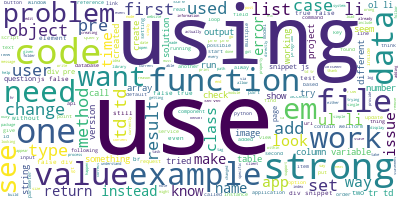

In [161]:
wordcloud_visualization(norm_tokens)

Результат в обычной форме (посчитаем частоты встречаемости слов и выведем первые 10 с их частотами):

In [162]:
token_freq = nltk.FreqDist(norm_tokens)
ten_most_common = token_freq.most_common(10)
print(ten_most_common)

[('code', 18674), ('use', 17822), ('using', 16678), ('like', 15384), ('strong', 14665), ('li', 14207), ('pre', 12841), ('want', 11967), ('get', 10692), ('file', 10652)]


Видно, что в последнее время пользователи StackOverflow пытались в свое работе использовать (use) код (code), и им это нравилось (like). Хотят еще (want).